In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.hooks as hooks
import transformer_lens.hook_points as hp

/home/aidan/Documents/Programming/autocircuit/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class MLP(nn.Module):
    def __init__(self, input, hidden, output):
        super().__init__()
        self.fc1 = nn.Linear(input, hidden)
        self.fc2 = nn.Linear(hidden, output)

        self.h0 = hp.HookPoint()
        self.h1 = hp.HookPoint()
        self.h2 = hp.HookPoint()
    
    def forward(self, x):
        x = self.h0(x)
        x = self.h1(F.relu(self.fc1(x)))
        return self.h2(self.fc2(x))
    
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=1, std=0.02)
                nn.init.normal_(m.bias, std=0.02)

In [3]:
import autocircuit.graphed_model as gm

In [4]:
class NeuronHook(gm.Hook):
    def __init__(self, hook_point, index):
        self.hook_point = hook_point
        self.index = index
    
    def add_hook(self, fn):
        def go(tensor, hook=None):
            out = fn(tensor[:, self.index])
            tensor[:, self.index] = out
            return tensor
        self.hook_point.add_hook(go)

In [5]:
class NeuronHookManager:
    def __init__(self, hooks):
        self.hooks = hooks
    
    def remove_hooks(self):
        for hook in self.hooks:
            try:
                self.hooks[hook].hook_point.remove_hooks()
            except:
                print(hook)

In [6]:
def gen_neuron_graph(input, hidden, output):
    mlp = MLP(input, hidden, output)
    graph = gm.ComputeGraph([], [], "output")
    nodes = {}

    for o in range(output):
        nodes[f"output_{o}"] = NeuronHook(mlp.h2, o)
        graph.nodes.append(f"output_{o}")
    for h in range(hidden):
        nodes[f"hidden_{h}"] = NeuronHook(mlp.h1, h)
        graph.nodes.append(f"hidden_{h}")
    for i in range(input):
        nodes[f"input_{i}"] = NeuronHook(mlp.h0, i)
        graph.nodes.append(f"input_{i}")
    
    graph.edges = [(f"output_{o}", f"hidden_{h}") for o in range(output) for h in range(hidden)]
    graph.edges += [(f"hidden_{h}", f"input_{i}") for h in range(hidden) for i in range(input)]

    return gm.GraphedModel(mlp, graph, NeuronHookManager(nodes))

In [7]:
model = gen_neuron_graph(2, 8, 2)

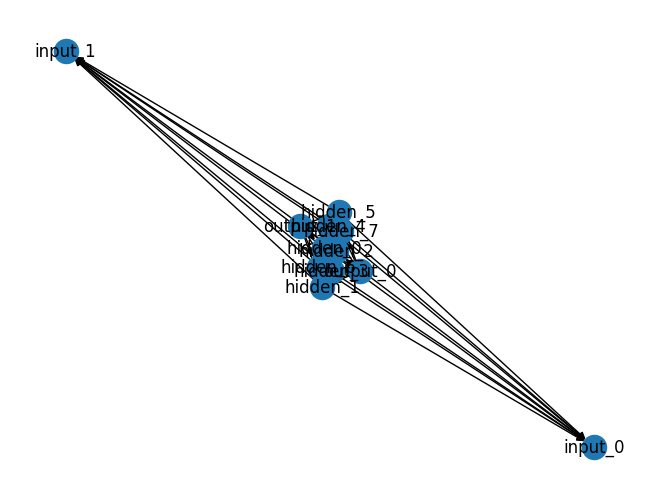

In [8]:
import autocircuit.visualise as vis

vis.draw_graph(model.graph)

In [9]:
# train the model to calculate x**2
import torch.optim as optim

model.hook_manager.remove_hooks()
mlp = model.model

opt = optim.Adam(mlp.parameters(), lr=0.01)

for i in range(1000):
    opt.zero_grad()
    x = torch.rand(128, 2)
    y = x ** 2
    out = mlp(x)
    loss = F.mse_loss(out, y)
    loss.backward()
    opt.step()

In [10]:
import autocircuit as ac

In [11]:
_, ac_cache = model.run_with_cache(torch.rand(100, 2))

In [12]:
print(model.graph.get_children("output_0"))

['hidden_0', 'hidden_1', 'hidden_2', 'hidden_3', 'hidden_4', 'hidden_5', 'hidden_6', 'hidden_7']


In [40]:
out = ac.autocircuit(model, "output_0", torch.tensor([[1, 0]], dtype=torch.float), ac_cache, 0.05, ablation_mode="mean")

node output_0 baseline torch.Size([1, 2])
ablated hidden_0
ablated hidden_1
ablated hidden_2
ablated hidden_3
ablated hidden_4
ablated hidden_5
ablated hidden_6
ablated hidden_7
output_0 has important children ['hidden_0', 'hidden_3', 'hidden_4'] and mean diff 0.030224389661498208
node hidden_0 baseline torch.Size([1, 2])
ablated input_0
ablated input_1
hidden_0 has important children ['input_0', 'input_1'] and mean diff 0.1547701433300972
node hidden_3 baseline torch.Size([1, 2])
ablated input_0
ablated input_1
hidden_3 has important children [] and mean diff 0.0
node hidden_4 baseline torch.Size([1, 2])
ablated input_0
ablated input_1
hidden_4 has important children [] and mean diff 0.0
node input_0 baseline torch.Size([1, 2])
node input_1 baseline torch.Size([1, 2])


In [41]:
print(out.nodes)

['output_0', 'hidden_0', 'hidden_3', 'hidden_4', 'input_0', 'input_1']


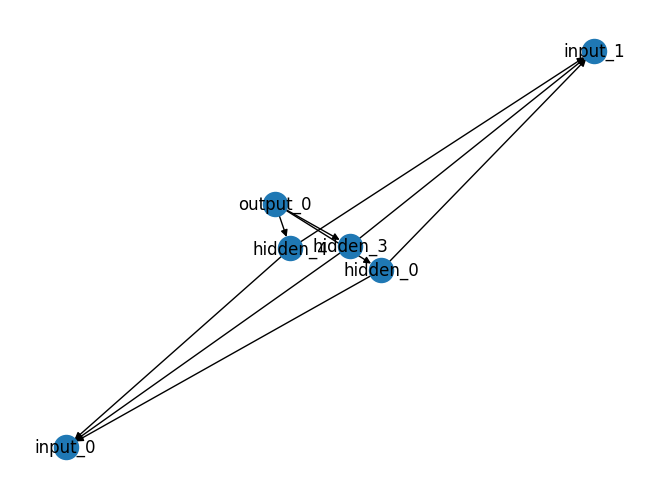

In [42]:
vis.draw_graph(out)